In [1]:
# !git clone https://github.com/yysijie/st-gcn.git
# %cd st-gcn
# !pip install torch torchvision
# !pip install -r requirements.txt
# !mkdir -p models
# !cp /kaggle/working/st-gcn/models/


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader


file_path = "/kaggle/input/pose-estimate/datasets/preprocessed_dataset.csv"  # Update with your file path
data = pd.read_csv(file_path)


NUM_NODES = 7 
NUM_FEATURES = 2  
NUM_TIMESTEPS = 14 

node_columns = [
    'head_x', 'head_y',
    'beak_base_x', 'beak_base_y',
    'beak_tip_x', 'beak_tip_y',
    'neck_x', 'neck_y',
    'body1_x', 'body1_y',
    'body2_x', 'body2_y',
    'tail_base_x', 'tail_base_y',
]


adjacency_matrix = np.array([
    [0, 1, 0, 1, 0, 0, 0],  # head
    [1, 0, 1, 0, 0, 0, 0],  # beak_base
    [0, 1, 0, 0, 0, 0, 0],  # beak_tip
    [1, 0, 0, 0, 1, 0, 0],  # neck
    [0, 0, 0, 1, 0, 1, 0],  # body1
    [0, 0, 0, 0, 1, 0, 1],  # body2
    [0, 0, 0, 0, 0, 1, 0],  # tail_base
], dtype=np.float32)


In [3]:
data.head()

,behavior,image_id,image_file,head_x,head_y,beak_base_x,beak_base_y,beak_tip_x,beak_tip_y,neck_x,neck_y,body1_x,body1_y,body2_x,body2_y,tail_base_x,tail_base_y
0,nesting,n_001,59-20151230231705-00.jpg,19.234443,92.112384,41.246921,134.089668,39.711167,149.447212,61.211727,86.993203,79.640779,136.137341,123.153818,131.530078,176.393301,7.133978
1,nesting,n_001,59-20151230231706-00.jpg,12.579507,49.111263,43.806512,116.684453,55.580628,136.137341,70.426253,83.921694,83.736124,139.208850,145.166297,131.018160,164.619185,5.086305
2,nesting,n_001,59-20151230231714-00.jpg,24.865542,28.634538,38.175412,83.921694,35.615822,99.279237,61.211727,54.742362,86.295715,137.161177,139.535198,132.553914,193.286599,5.086305
3,nesting,n_001,59-20151230231720-00.jpg,23.841705,105.934174,38.175412,120.267882,42.270757,127.946653,49.949529,112.589110,73.497762,132.553916,111.379702,121.291718,126.225327,-0.544792
4,nesting,n_001,59-20151230231721-00.jpg,26.913214,101.838830,37.151576,117.708291,44.318430,125.387062,51.997201,109.005683,66.842826,139.720769,104.212848,131.018162,141.070952,3.550553


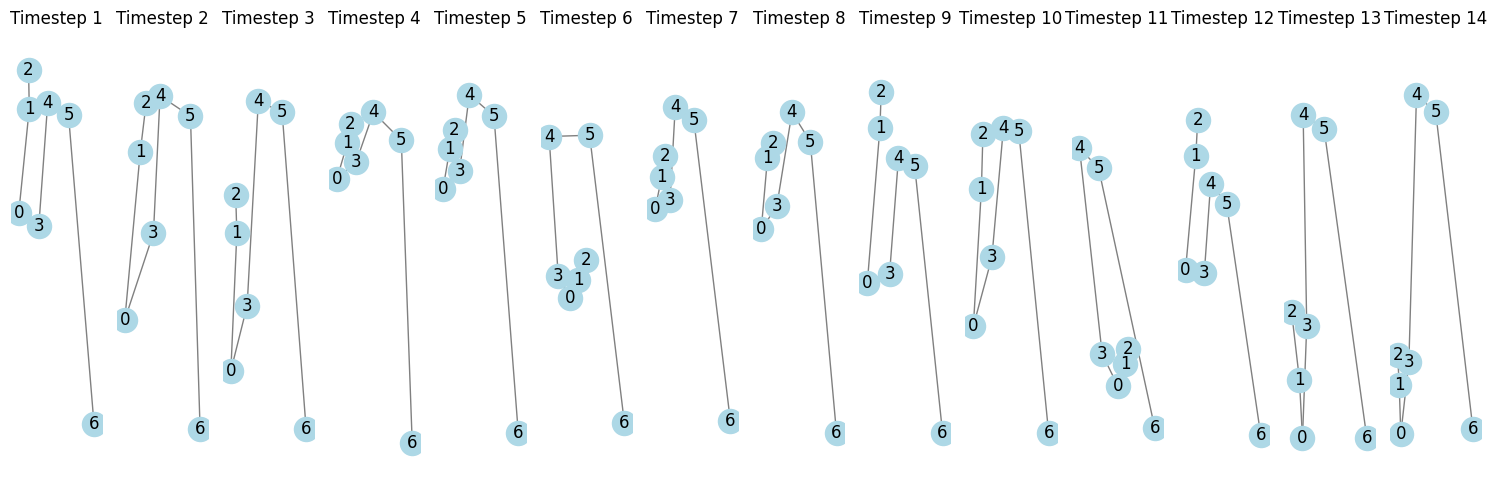

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


image_id = data['image_id'].unique()[0]  # Replace with desired image_id
subset = data[data['image_id'] == image_id]

# Create a function to plot the graph
def draw_stgcn(data, adjacency_matrix, num_timesteps):
    fig, axes = plt.subplots(1, num_timesteps, figsize=(15, 5), sharey=True)
    for t in range(num_timesteps):
        ax = axes[t]
        
        
        timestep_data = data.iloc[t]
        
       
        node_positions = {
            0: (timestep_data['head_x'], timestep_data['head_y']),
            1: (timestep_data['beak_base_x'], timestep_data['beak_base_y']),
            2: (timestep_data['beak_tip_x'], timestep_data['beak_tip_y']),
            3: (timestep_data['neck_x'], timestep_data['neck_y']),
            4: (timestep_data['body1_x'], timestep_data['body1_y']),
            5: (timestep_data['body2_x'], timestep_data['body2_y']),
            6: (timestep_data['tail_base_x'], timestep_data['tail_base_y']),
        }
        
        G = nx.Graph()
        for i in range(NUM_NODES):
            G.add_node(i, pos=node_positions[i])
            for j in range(NUM_NODES):
                if adjacency_matrix[i, j] == 1:
                    G.add_edge(i, j)
        
       
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', edge_color='gray', node_size=300)
        ax.set_title(f'Timestep {t + 1}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


draw_stgcn(subset, adjacency_matrix, NUM_TIMESTEPS)


In [5]:
videos = []
video_labels = []
for image_id, group in data.groupby('image_id'):
    frames = group[node_columns].values.reshape(-1, NUM_NODES, NUM_FEATURES)


    if frames.shape[0] > NUM_TIMESTEPS:
        frames = frames[:NUM_TIMESTEPS]
    elif frames.shape[0] < NUM_TIMESTEPS:
        padding = np.zeros((NUM_TIMESTEPS - frames.shape[0], NUM_NODES, NUM_FEATURES))
        frames = np.concatenate([frames, padding], axis=0)

    videos.append(frames)
    video_labels.append(group['behavior'].iloc[0])  # Ensure 'behavior' column exists


In [6]:

input_tensor = np.array(videos)  
video_labels = np.array(video_labels)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(video_labels)

input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

train_x, val_x, train_y, val_y = train_test_split(input_tensor, labels, test_size=0.2, random_state=42)
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [7]:
train_x

tensor([[[[ 1.3134e+02,  6.1101e+00],
          [ 1.0677e+02,  4.1432e+01],
          [ 8.3224e+01,  5.7302e+01],
          ...,
          [ 1.6513e+02,  1.5866e+02],
          [ 2.7980e+02,  1.4433e+02],
          [ 3.5461e+02,  2.8534e+00]],

         [[ 8.6575e+01,  2.8315e+01],
          [ 9.2886e+01,  7.3122e+01],
          [ 7.5847e+01,  9.5841e+01],
          ...,
          [ 1.6230e+02,  1.5706e+02],
          [ 2.4687e+02,  1.4948e+02],
          [ 3.5794e+02,  2.3267e+01]],

         [[ 9.6674e+01,  3.2328e+01],
          [ 8.9864e+01,  7.3940e+01],
          [ 7.8516e+01,  9.1341e+01],
          ...,
          [ 1.3526e+02,  1.3598e+02],
          [ 2.2605e+02,  1.5414e+02],
          [ 3.5845e+02,  1.6440e+01]],

         ...,

         [[ 1.1332e+02,  2.1736e+01],
          [ 1.0197e+02,  6.7887e+01],
          [ 8.3055e+01,  8.3019e+01],
          ...,
          [ 1.4509e+02,  1.4884e+02],
          [ 2.5555e+02,  1.4733e+02],
          [ 3.4634e+02,  1.8710e+01]],

     

In [8]:
class STGCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, A, num_nodes, stride=1, residual=True):  # Corrected __init__
        super(STGCNLayer, self).__init__()
        self.graph_conv = nn.Conv2d(in_channels, out_channels, kernel_size=(1, num_nodes), stride=(stride, 1))
        self.temporal_conv = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 1), padding=(1, 0), stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.residual = residual

        if not residual:
            self.residual_connection = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual_connection = lambda x: x
        else:
            self.residual_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=(stride, 1))

    def forward(self, x):
        res = self.residual_connection(x)
        x = self.graph_conv(x)
        x = self.temporal_conv(x)
        x = self.bn(x)
        x = self.relu(x + res)
        return x


In [9]:
class STGCN(nn.Module):
    def __init__(self, num_classes, A, num_nodes, num_features, num_timesteps):  # Corrected __init__
        super(STGCN, self).__init__()
        self.data_bn = nn.BatchNorm1d(num_nodes * num_features)
        self.A = torch.tensor(A, dtype=torch.float32, requires_grad=False).unsqueeze(0).unsqueeze(0)

        self.layer1 = STGCNLayer(num_features, 64, self.A, num_nodes)
        self.layer2 = STGCNLayer(64, 128, self.A, num_nodes)
        self.layer3 = STGCNLayer(128, 256, self.A, num_nodes)


        self.num_classes = num_classes
        self.num_timesteps = num_timesteps

    def forward(self, x):
        N, T, V, C = x.shape

        # Rearrange to (N, C, T, V)
        x = x.permute(0, 3, 1, 2)

        # Apply batch normalization
        x = x.contiguous().view(N, C * V, T)  # Combine (C, V) for normalization
        x = self.data_bn(x)
        x = x.view(N, C, V, T).permute(0, 1, 3, 2)  # (N, C, T, V)

        # Pass through STGCN layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = x.view(N, -1)  # Flatten

        # Lazy initialization of fc layer
        if not hasattr(self, 'fc'):
            self.fc = nn.Linear(x.size(1), self.num_classes).to(x.device)

        x = self.fc(x)
        return x


In [10]:
# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(label_encoder.classes_)
model = STGCN(num_classes, adjacency_matrix, NUM_NODES, NUM_FEATURES, NUM_TIMESTEPS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
for epoch in range(20):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    print(f"Epoch {epoch+1}/{20}, Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch 1/20, Train Loss: 0.9463, Val Loss: 0.7145, Accuracy: 44.44%
Epoch 2/20, Train Loss: 0.3337, Val Loss: 0.6829, Accuracy: 44.44%
Epoch 3/20, Train Loss: 0.3326, Val Loss: 0.7273, Accuracy: 44.44%
Epoch 4/20, Train Loss: 0.0783, Val Loss: 1.0418, Accuracy: 44.44%
Epoch 5/20, Train Loss: 0.1681, Val Loss: 0.9156, Accuracy: 44.44%
Epoch 6/20, Train Loss: 0.0567, Val Loss: 0.7205, Accuracy: 66.67%
Epoch 7/20, Train Loss: 0.0341, Val Loss: 0.5768, Accuracy: 77.78%
Epoch 8/20, Train Loss: 0.0386, Val Loss: 0.5246, Accuracy: 77.78%
Epoch 9/20, Train Loss: 0.0141, Val Loss: 0.5053, Accuracy: 88.89%
Epoch 10/20, Train Loss: 0.0141, Val Loss: 0.5042, Accuracy: 88.89%
Epoch 11/20, Train Loss: 0.0143, Val Loss: 0.5015, Accuracy: 88.89%
Epoch 12/20, Train Loss: 0.0221, Val Loss: 0.4639, Accuracy: 88.89%
Epoch 13/20, Train Loss: 0.0046, Val Loss: 0.4549, Accuracy: 88.89%
Epoch 14/20, Train Loss: 0.0051, Val Loss: 0.4585, Accuracy: 88.89%
Epoch 15/20, Train Loss: 0.0046, Val Loss: 0.4742, Accura

In [12]:
# Training loop
for epoch in range(20):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()


            predictions.extend(predicted.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())


    print(f"Epoch {epoch+1}/{20}, Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    print("Validation Predictions vs Actuals:")
    for pred, actual in zip(predictions, actuals):
        pred_label = label_encoder.inverse_transform([pred])[0]
        actual_label = label_encoder.inverse_transform([actual])[0]
        print(f"Predicted: {pred_label}, Actual: {actual_label}")

Epoch 1/20, Train Loss: 0.0023, Val Loss: 0.6714, Accuracy: 88.89%
Validation Predictions vs Actuals:
Predicted: preening, Actual: preening
Predicted: nesting, Actual: nesting
Predicted: nesting, Actual: nesting
Predicted: preening, Actual: preening
Predicted: nesting, Actual: nesting
Predicted: preening, Actual: preening
Predicted: nesting, Actual: nesting
Predicted: nesting, Actual: preening
Predicted: preening, Actual: preening
Epoch 2/20, Train Loss: 0.0013, Val Loss: 0.6911, Accuracy: 88.89%
Validation Predictions vs Actuals:
Predicted: preening, Actual: preening
Predicted: nesting, Actual: nesting
Predicted: nesting, Actual: nesting
Predicted: preening, Actual: preening
Predicted: nesting, Actual: nesting
Predicted: preening, Actual: preening
Predicted: nesting, Actual: nesting
Predicted: nesting, Actual: preening
Predicted: preening, Actual: preening
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.7028, Accuracy: 88.89%
Validation Predictions vs Actuals:
Predicted: preening, Actual: